<a href="https://colab.research.google.com/github/aayisha-muhammed/Ayisha/blob/main/rainfallprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
# Instead of importing plot_confusion_matrix and plot_roc_curve directly,
# import ConfusionMatrixDisplay and RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
# Load dataset
file_path = '/content/weatherAUS.csv'
df = pd.read_csv(file_path)

# Inspect the dataset
df.head()



<ipython-input-3-5d60329643ea>:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,02-12-2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,03-12-2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,04-12-2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,05-12-2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53658 entries, 0 to 53657
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           53658 non-null  object 
 1   Location       53658 non-null  object 
 2   MinTemp        53043 non-null  float64
 3   MaxTemp        53215 non-null  float64
 4   Rainfall       52233 non-null  float64
 5   Evaporation    24047 non-null  float64
 6   Sunshine       18441 non-null  float64
 7   WindGustDir    47817 non-null  object 
 8   WindGustSpeed  47824 non-null  float64
 9   WindDir9am     47426 non-null  object 
 10  WindDir3pm     50988 non-null  object 
 11  WindSpeed9am   52312 non-null  float64
 12  WindSpeed3pm   51690 non-null  float64
 13  Humidity9am    52438 non-null  float64
 14  Humidity3pm    51954 non-null  float64
 15  Pressure9am    45067 non-null  float64
 16  Pressure3pm    45118 non-null  object 
 17  Cloud9am       29614 non-null  float64
 18  Cloud3

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

# Drop rows where target 'RainTomorrow' is missing
df = df.dropna(subset=['RainTomorrow'])

# Impute missing values for other features (for numeric and categorical separately)
from sklearn.impute import SimpleImputer

# Impute numeric columns
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
imputer_num = SimpleImputer(strategy='mean')

# Use .loc to avoid SettingWithCopyWarning
df.loc[:, numeric_features] = imputer_num.fit_transform(df[numeric_features])

# Impute categorical columns
categorical_features = df.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='most_frequent')

# Use .loc to avoid SettingWithCopyWarning
df.loc[:, categorical_features] = imputer_cat.fit_transform(df[categorical_features])


Date                 0
Location             0
MinTemp            615
MaxTemp            443
Rainfall          1425
Evaporation      29611
Sunshine         35217
WindGustDir       5841
WindGustSpeed     5834
WindDir9am        6232
WindDir3pm        2670
WindSpeed9am      1346
WindSpeed3pm      1968
Humidity9am       1220
Humidity3pm       1704
Pressure9am       8591
Pressure3pm       8540
Cloud9am         24044
Cloud3pm         24482
Temp9am            925
Temp3pm           1451
RainToday         1426
RainTomorrow      1425
dtype: int64


In [9]:
missing_values = df.isnull().sum()
print(missing_values)

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64


In [10]:
df.shape[0]

52233

In [11]:
from sklearn.preprocessing import LabelEncoder

# Encoding categorical variables
le = LabelEncoder()
df['RainTomorrow'] = le.fit_transform(df['RainTomorrow'])
df['RainToday'] = le.fit_transform(df['RainToday'])

for col in categorical_features:
    # Check if the column has mixed types
    if df[col].apply(type).nunique() > 1:
        # If mixed types, convert all values to strings
        df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col]) # Now apply Label Encoding

In [12]:
from sklearn.preprocessing import StandardScaler

# Scale numeric features
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])


#outlier

In [13]:
# prompt: check outlier

# Identify outliers using IQR for numeric features
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return outliers

for feature in numeric_features:
    outliers = detect_outliers_iqr(df[feature])
    if outliers.any():
        print(f"Outliers detected in {feature}:")
        print(df[outliers][feature])
        # You can handle outliers here (e.g., remove them, cap them, etc.)
        # Example: Remove outliers
        # df = df[~outliers]


# You can also visualize outliers using box plots:
# for feature in numeric_features:
#     plt.figure(figsize=(8, 6))
#     sns.boxplot(x=df[feature])
#     plt.title(f'Box Plot of {feature}')
#     plt.show()

Outliers detected in MinTemp:
46848   -3.032914
46849   -2.969312
46909   -2.937511
46922   -2.937511
46923   -3.207819
46924   -3.001113
47250   -2.937511
47264   -2.905710
47293   -2.985212
47323   -3.017013
47966   -2.905710
47967   -3.144217
47968   -3.017013
48268   -3.048814
48270   -3.032914
48299   -3.048814
49598   -3.001113
49962   -2.921611
49963   -3.239620
49964   -3.048814
50302   -2.905710
50306   -2.921611
51006   -2.905710
51307   -2.937511
51338   -2.969312
52253   -3.001113
52254   -3.287321
52312   -2.937511
52330   -2.937511
52362   -2.905710
52637   -3.207819
52686   -2.905710
52694   -3.064715
52924   -2.953412
52984   -2.969312
52987   -2.969312
52988   -2.985212
53045   -2.985212
53380   -2.953412
53402   -2.921611
Name: MinTemp, dtype: float64
Outliers detected in MaxTemp:
44       3.076586
50       2.599283
58       2.722458
59       2.845633
60       3.061189
           ...   
53651   -3.728840
53652   -3.590268
53653   -3.374711
53654   -3.189949
53655   -3

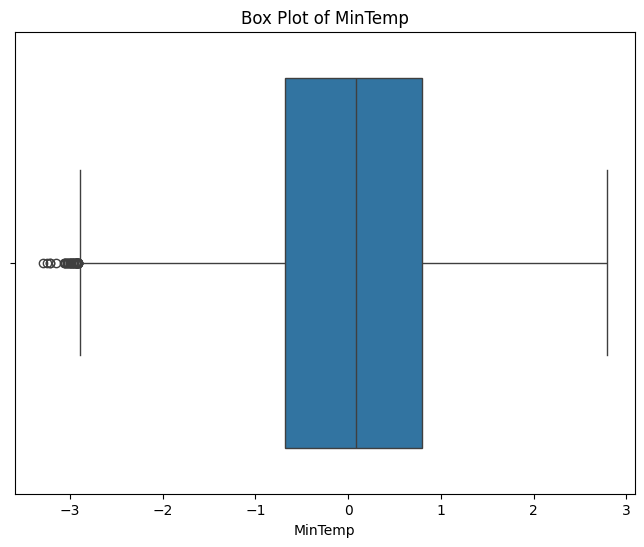

Outliers detected in MinTemp:
46848   -3.032914
46849   -2.969312
46909   -2.937511
46922   -2.937511
46923   -3.207819
46924   -3.001113
47250   -2.937511
47264   -2.905710
47293   -2.985212
47323   -3.017013
47966   -2.905710
47967   -3.144217
47968   -3.017013
48268   -3.048814
48270   -3.032914
48299   -3.048814
49598   -3.001113
49962   -2.921611
49963   -3.239620
49964   -3.048814
50302   -2.905710
50306   -2.921611
51006   -2.905710
51307   -2.937511
51338   -2.969312
52253   -3.001113
52254   -3.287321
52312   -2.937511
52330   -2.937511
52362   -2.905710
52637   -3.207819
52686   -2.905710
52694   -3.064715
52924   -2.953412
52984   -2.969312
52987   -2.969312
52988   -2.985212
53045   -2.985212
53380   -2.953412
53402   -2.921611
Name: MinTemp, dtype: float64


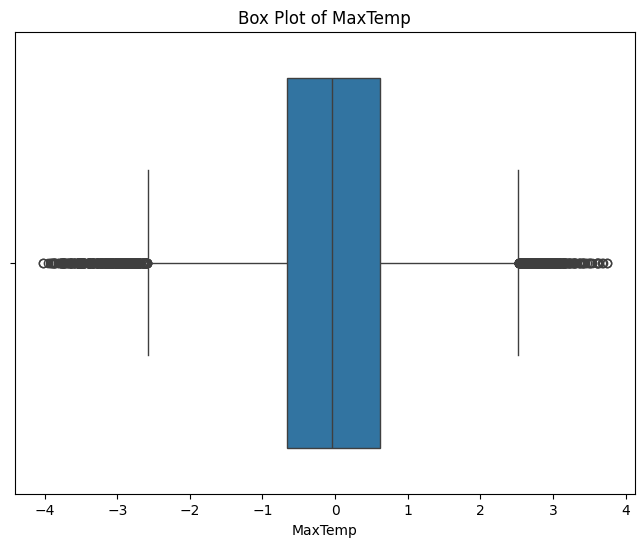

Outliers detected in MaxTemp:
44       3.076586
50       2.599283
58       2.722458
59       2.845633
60       3.061189
           ...   
53651   -3.728840
53652   -3.590268
53653   -3.374711
53654   -3.189949
53655   -3.066773
Name: MaxTemp, Length: 965, dtype: float64


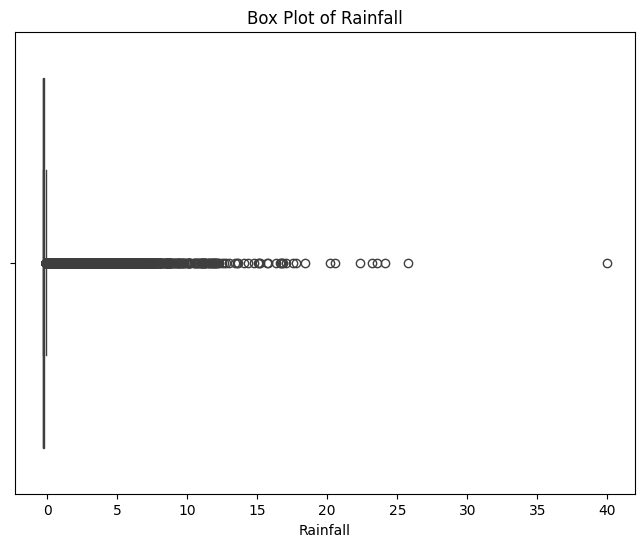

Outliers detected in Rainfall:
11      -5.002514e-02
12       1.403309e+00
13       1.018158e-01
15      -4.816493e-17
17       1.533458e+00
             ...     
53629    5.356469e-01
53639    3.187313e-01
53640    2.661419e+00
53650    2.536567e-01
53652   -2.833358e-02
Name: Rainfall, Length: 10171, dtype: float64


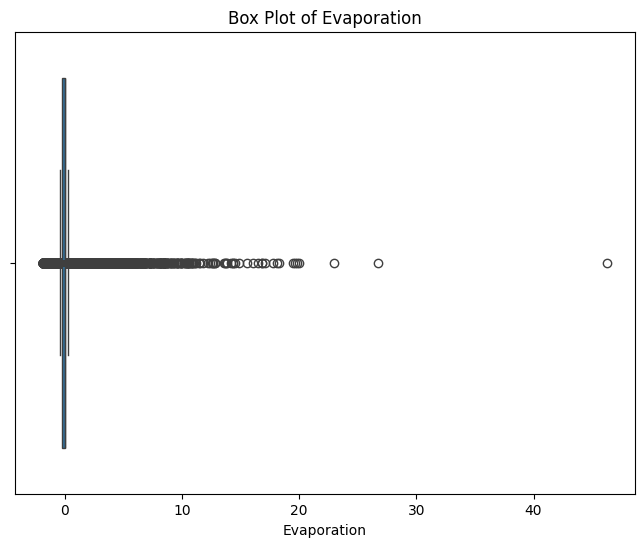

Outliers detected in Evaporation:
6049     2.147075
6050     3.075314
6051     2.345983
6052     1.749258
6053     1.948166
           ...   
47534   -1.565884
47536   -1.035461
47537   -1.499581
47540   -1.300672
47541   -1.300672
Name: Evaporation, Length: 18823, dtype: float64


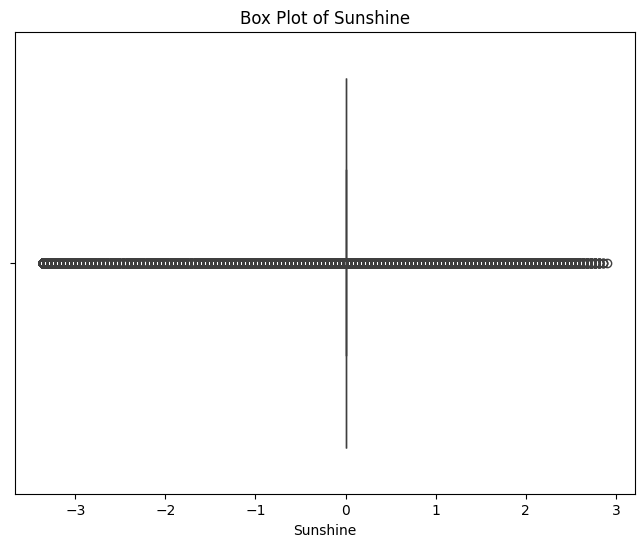

Outliers detected in Sunshine:
6049     2.098366
6050     2.408861
6051     2.541930
6052     1.344307
6053     2.054009
           ...   
47407    1.521732
47408    2.009653
47409   -1.095297
47410   -2.115495
47411   -2.115495
Name: Sunshine, Length: 18412, dtype: float64


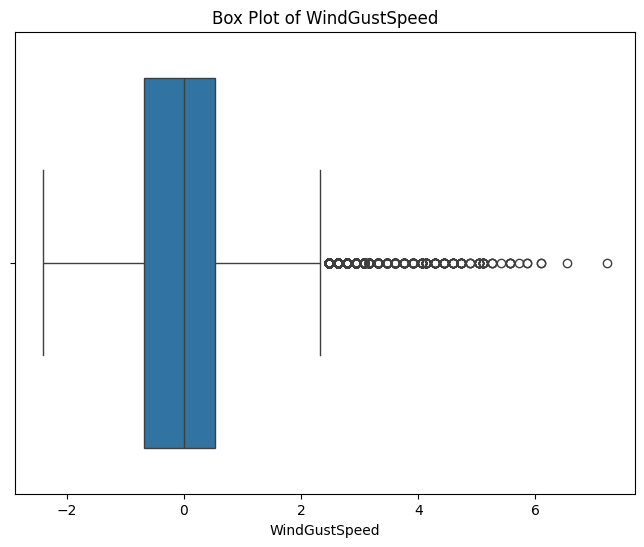

Outliers detected in WindGustSpeed:
8        3.081810
52       4.435120
62       3.307362
123      4.435120
211      2.480339
           ...   
53629    3.758465
53630    2.781074
53639    3.081810
53640    2.931442
53650    3.081810
Name: WindGustSpeed, Length: 1274, dtype: float64


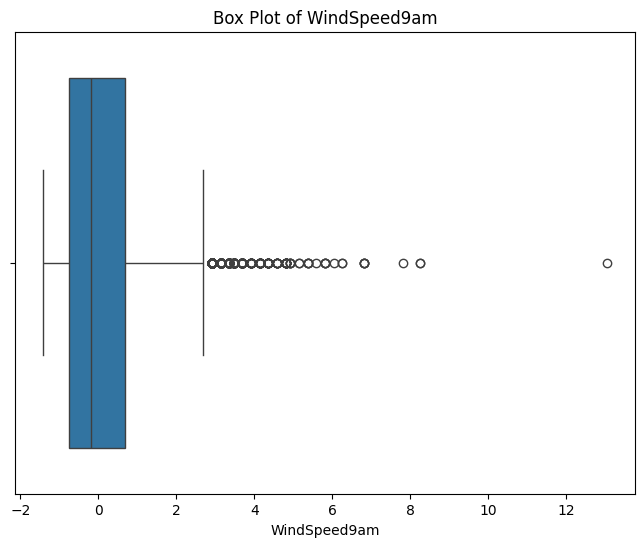

Outliers detected in WindSpeed9am:
3308     3.916692
3693     2.916215
5050     3.472035
9104     2.916215
9198     3.138543
           ...   
52872    3.472035
53187    3.138543
53224    3.360871
53225    3.694363
53380    3.916692
Name: WindSpeed9am, Length: 554, dtype: float64


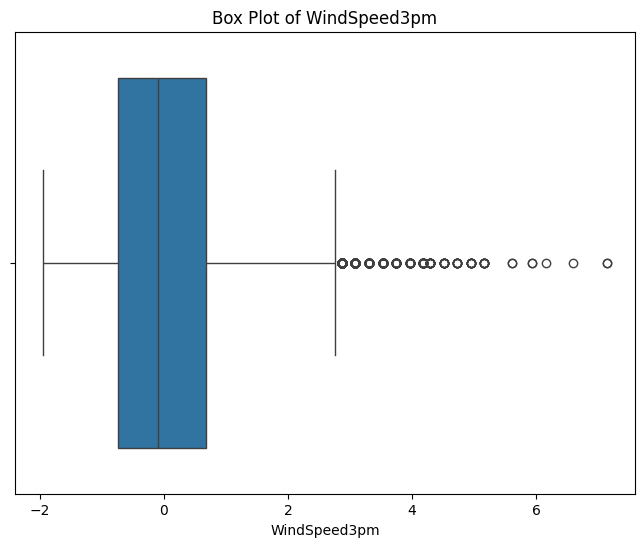

Outliers detected in WindSpeed3pm:
52       3.305118
356      3.086222
381      3.524015
1626     2.867325
1692     3.086222
           ...   
52333    3.086222
52443    2.867325
52745    3.305118
52809    2.867325
52983    3.742912
Name: WindSpeed3pm, Length: 521, dtype: float64


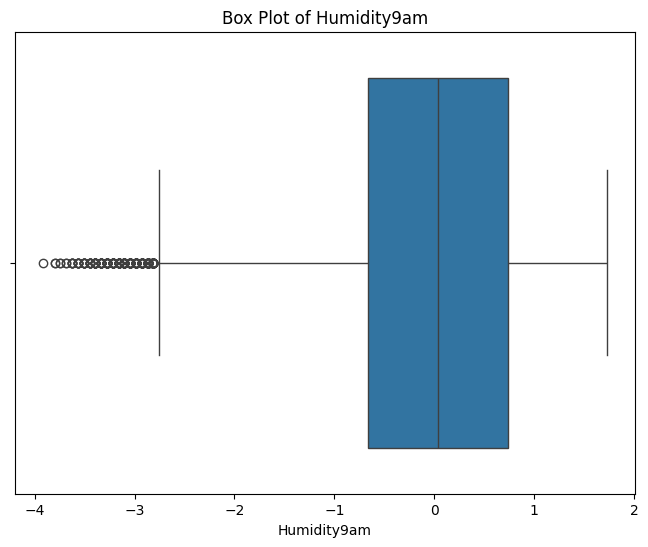

Outliers detected in Humidity9am:
69      -2.927950
388     -2.869758
2486    -3.044334
5816    -2.986142
6049    -2.927950
           ...   
53433   -3.044334
53587   -2.869758
53618   -3.218909
53624   -3.277100
53648   -2.927950
Name: Humidity9am, Length: 313, dtype: float64


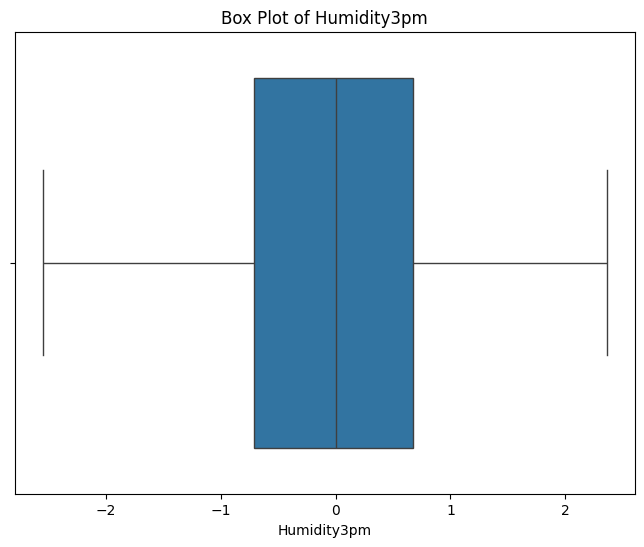

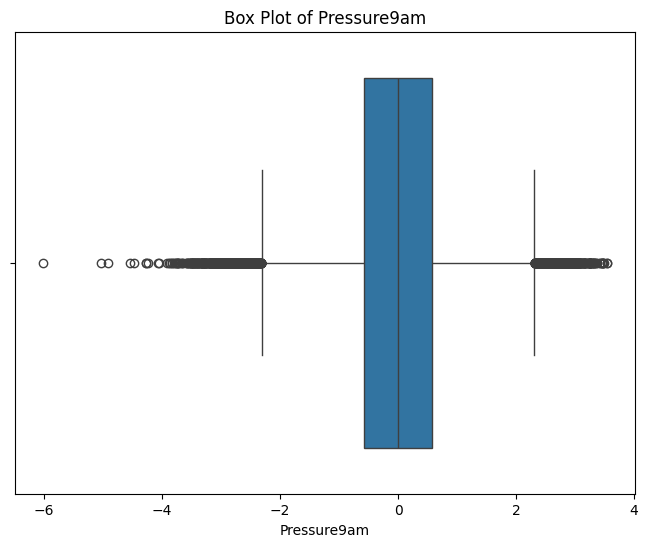

Outliers detected in Pressure9am:
12      -3.823573
13      -2.726621
181      2.503772
271     -2.504051
295     -2.504051
           ...   
52038    2.758138
52039    2.424283
52046    2.662751
52050    2.471977
52055    2.408385
Name: Pressure9am, Length: 1482, dtype: float64


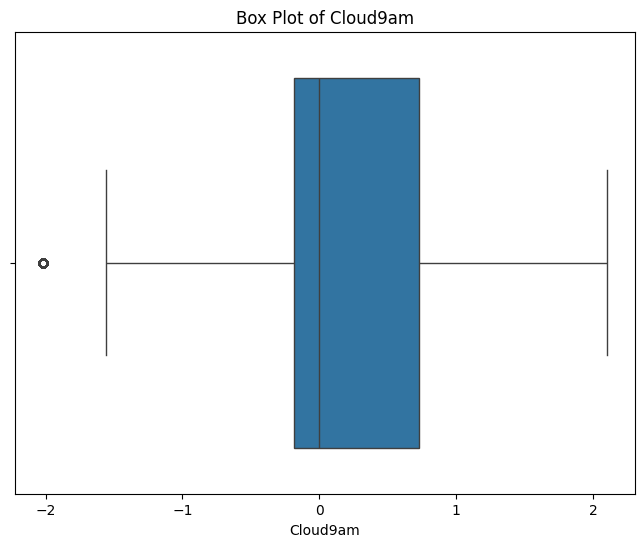

Outliers detected in Cloud9am:
15      -2.018708
6060    -2.018708
6061    -2.018708
6064    -2.018708
6065    -2.018708
           ...   
47516   -2.018708
47517   -2.018708
47524   -2.018708
47530   -2.018708
47540   -2.018708
Name: Cloud9am, Length: 2532, dtype: float64


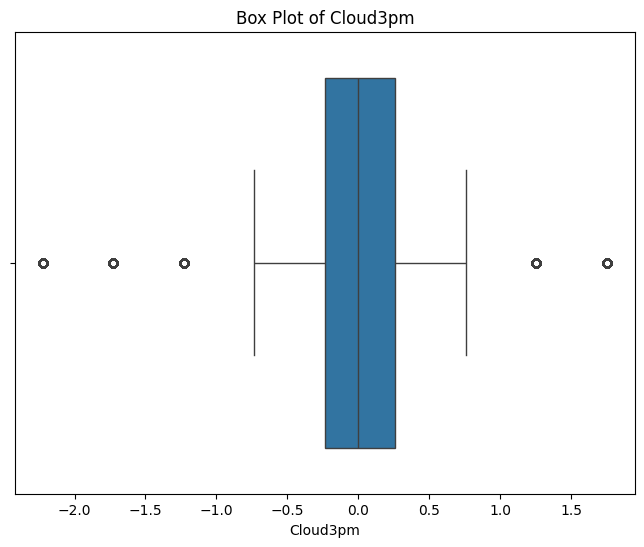

Outliers detected in Cloud3pm:
2       -1.228938
4        1.749382
11       1.749382
12       1.749382
13       1.252996
           ...   
49007    1.252996
49009   -1.725325
49012    1.749382
49013    1.749382
49014    1.749382
Name: Cloud3pm, Length: 19477, dtype: float64


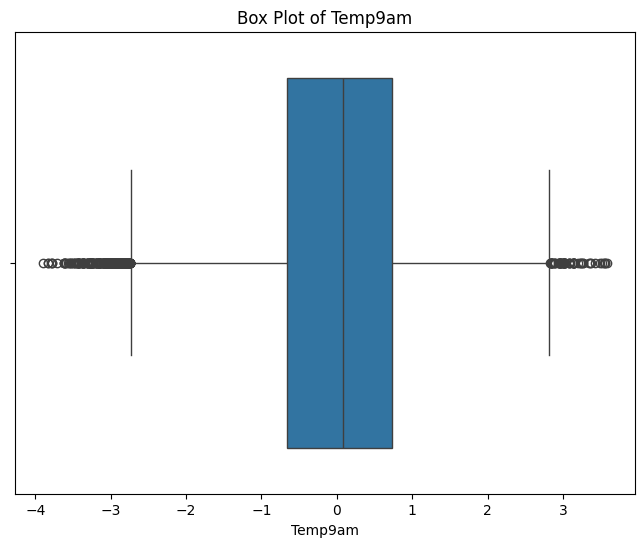

Outliers detected in Temp9am:
69       3.031551
1270    -2.833637
1438     3.031551
2486     2.894353
5890     3.563191
           ...   
53651   -3.348127
53652   -3.176631
53653   -3.056583
53654   -3.159481
53655   -3.022283
Name: Temp9am, Length: 407, dtype: float64


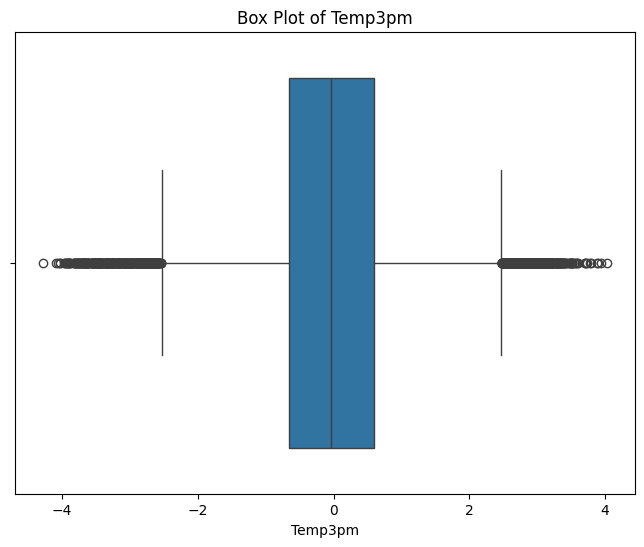

Outliers detected in Temp3pm:
37       2.695745
44       3.193047
50       2.583451
58       2.824081
59       2.968459
           ...   
53652   -3.576678
53653   -3.464384
53654   -3.432300
53655   -3.239796
53656   -2.742494
Name: Temp3pm, Length: 1098, dtype: float64


In [14]:
# prompt: give outlier shown in boxplot

# Visualize outliers using box plots and identify them
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()

    # Calculate the IQR and identify outliers
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]

    if not outliers.empty:
        print(f"Outliers detected in {feature}:")
        print(outliers)

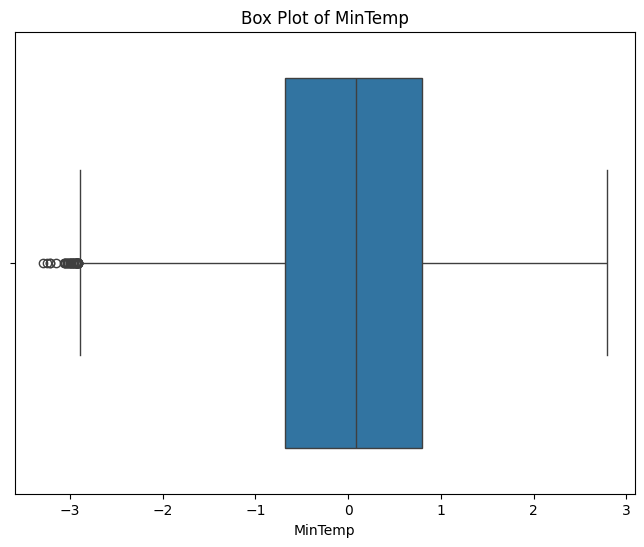

Outliers detected in MinTemp:
Removed 40 outliers from MinTemp


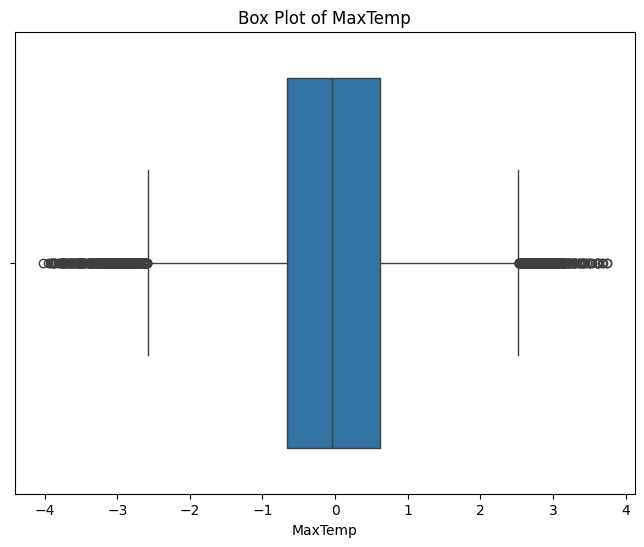

Outliers detected in MaxTemp:
Removed 950 outliers from MaxTemp


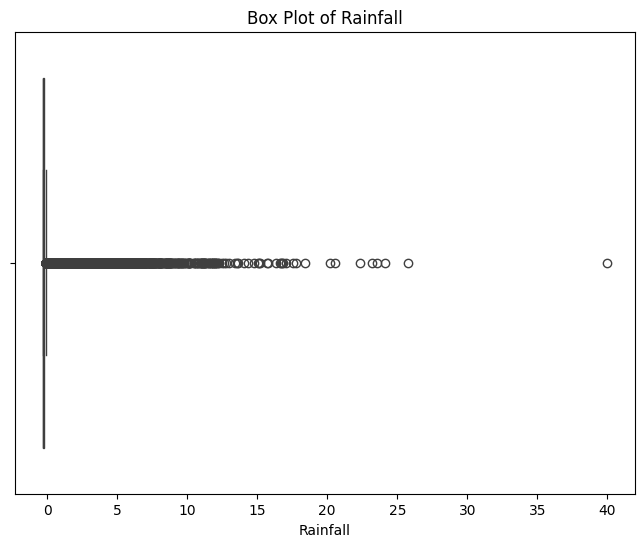

Outliers detected in Rainfall:
Removed 9974 outliers from Rainfall


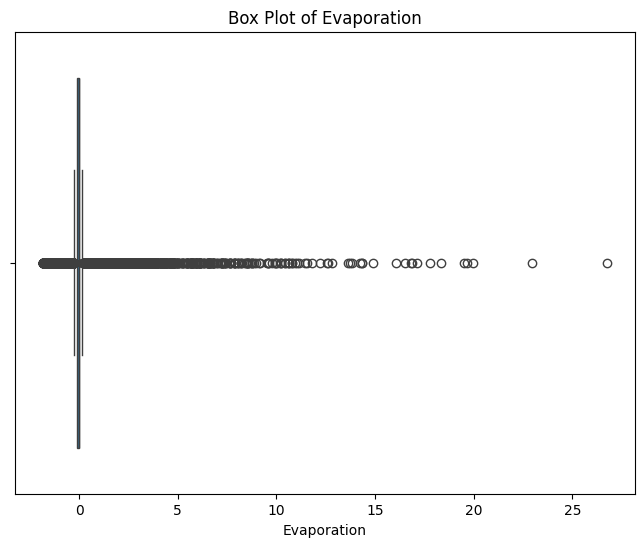

Outliers detected in Evaporation:
Removed 16253 outliers from Evaporation


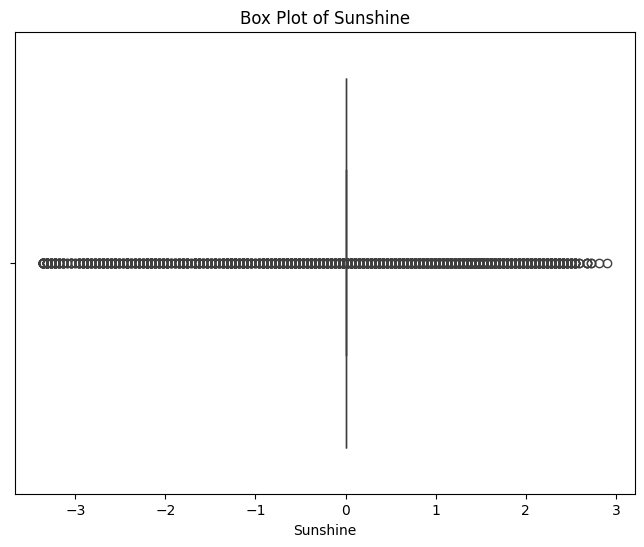

Outliers detected in Sunshine:
Removed 2481 outliers from Sunshine


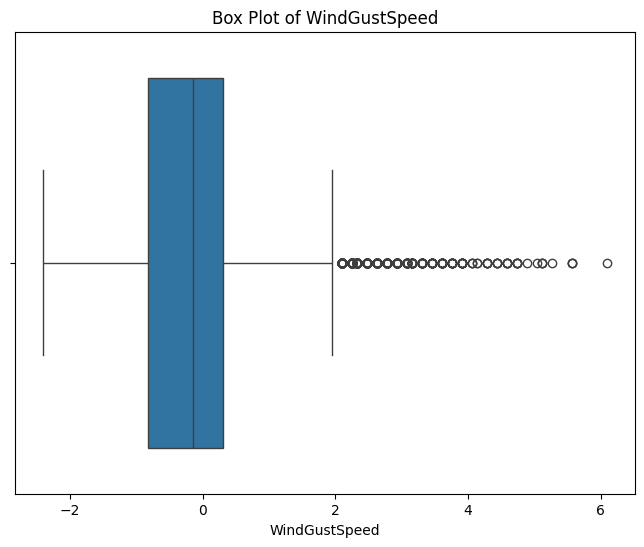

Outliers detected in WindGustSpeed:
Removed 712 outliers from WindGustSpeed


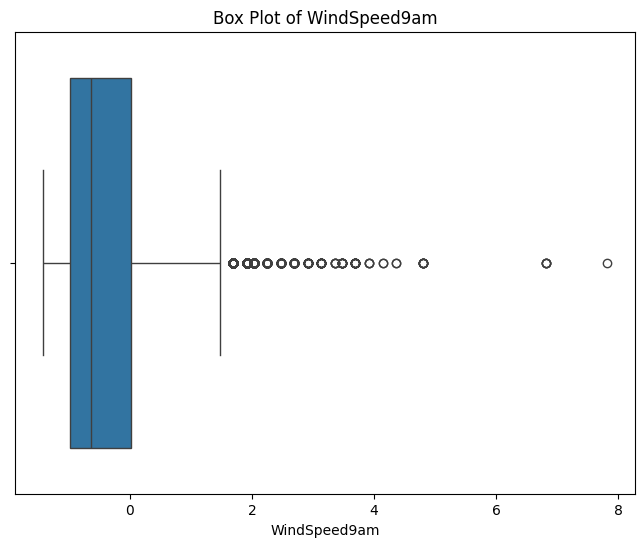

Outliers detected in WindSpeed9am:
Removed 750 outliers from WindSpeed9am


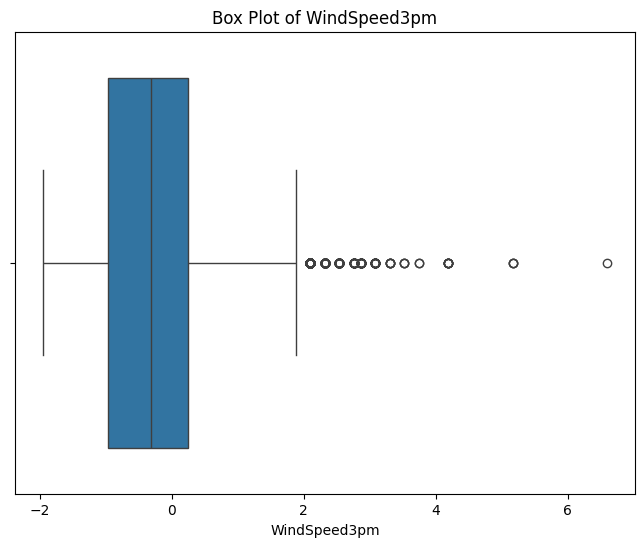

Outliers detected in WindSpeed3pm:
Removed 370 outliers from WindSpeed3pm


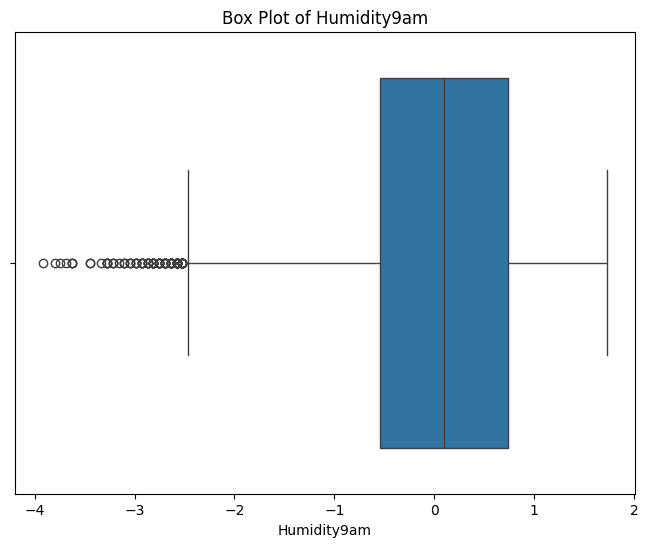

Outliers detected in Humidity9am:
Removed 104 outliers from Humidity9am


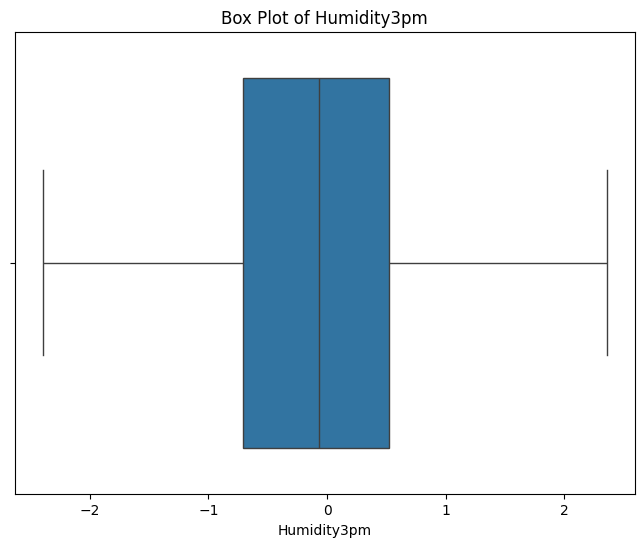

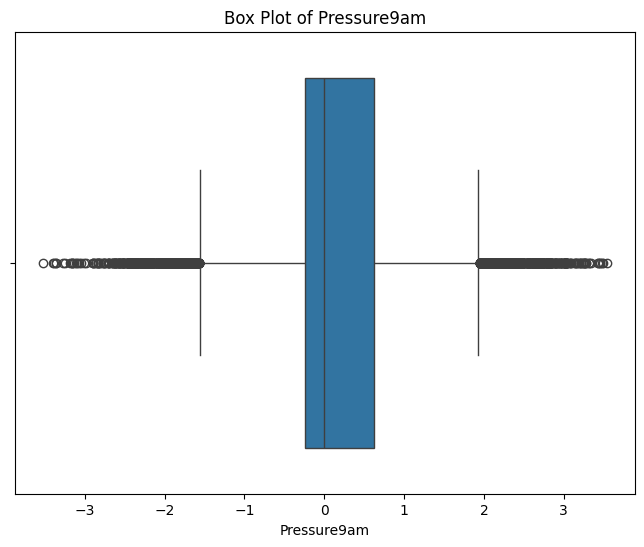

Outliers detected in Pressure9am:
Removed 1638 outliers from Pressure9am


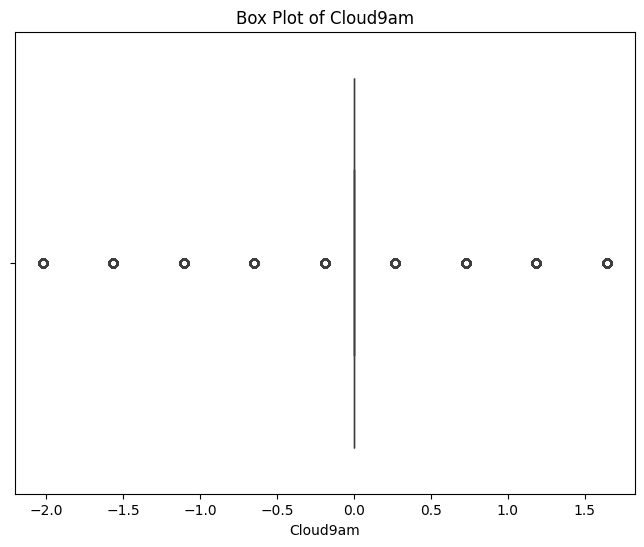

Outliers detected in Cloud9am:
Removed 4804 outliers from Cloud9am


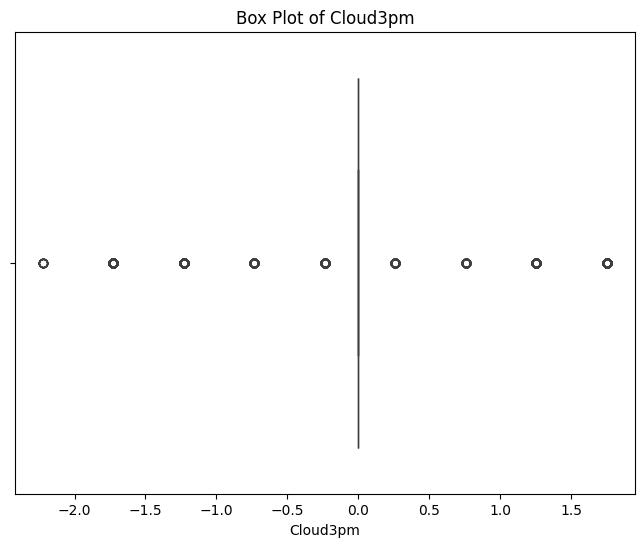

Outliers detected in Cloud3pm:
Removed 1244 outliers from Cloud3pm


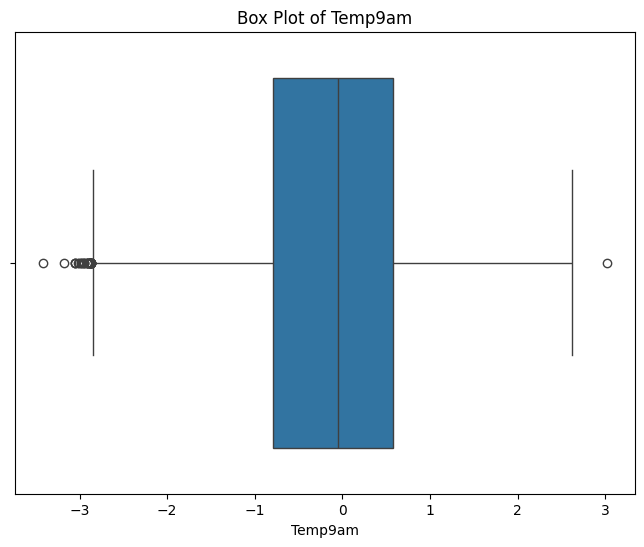

Outliers detected in Temp9am:
Removed 33 outliers from Temp9am


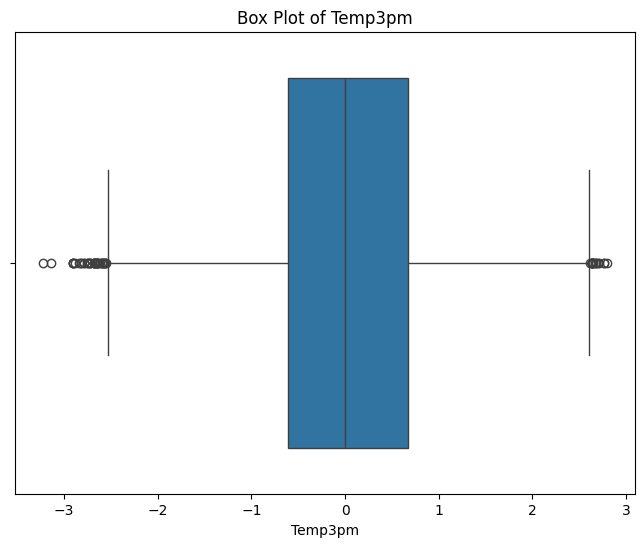

Outliers detected in Temp3pm:
Removed 58 outliers from Temp3pm


In [15]:
# prompt: remove the outlier withboxplot

# ... (Your existing code)

# Visualize outliers using box plots and remove them
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.show()

    # Calculate the IQR and identify outliers
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index

    if not outliers.empty:
        print(f"Outliers detected in {feature}:")
        # Remove outliers
        df.drop(outliers, inplace=True)
        print(f"Removed {len(outliers)} outliers from {feature}")

# ... (Rest of your code)

In [16]:
df.shape[0]

12822

In [17]:
import os

# Create the directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# Save the heatmap after creating the directory
plt.savefig('images/corr_heatmap.png', facecolor='white', dpi=100)


<Figure size 640x480 with 0 Axes>

In [18]:
# Save the heatmap in the current directory
plt.savefig('corr_heatmap.png', facecolor='white', dpi=100)


<Figure size 640x480 with 0 Axes>

In [19]:
print(df[['Cloud9am', 'Cloud3pm']].isnull().sum())


Cloud9am    0
Cloud3pm    0
dtype: int64


In [20]:
# Impute Cloud9am and Cloud3pm if needed
df['Cloud9am'].fillna(df['Cloud9am'].mean(), inplace=True)
df['Cloud3pm'].fillna(df['Cloud3pm'].mean(), inplace=True)


<ipython-input-20-381e55fff946>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Cloud9am'].fillna(df['Cloud9am'].mean(), inplace=True)
<ipython-input-20-381e55fff946>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

#Correlation Matrix


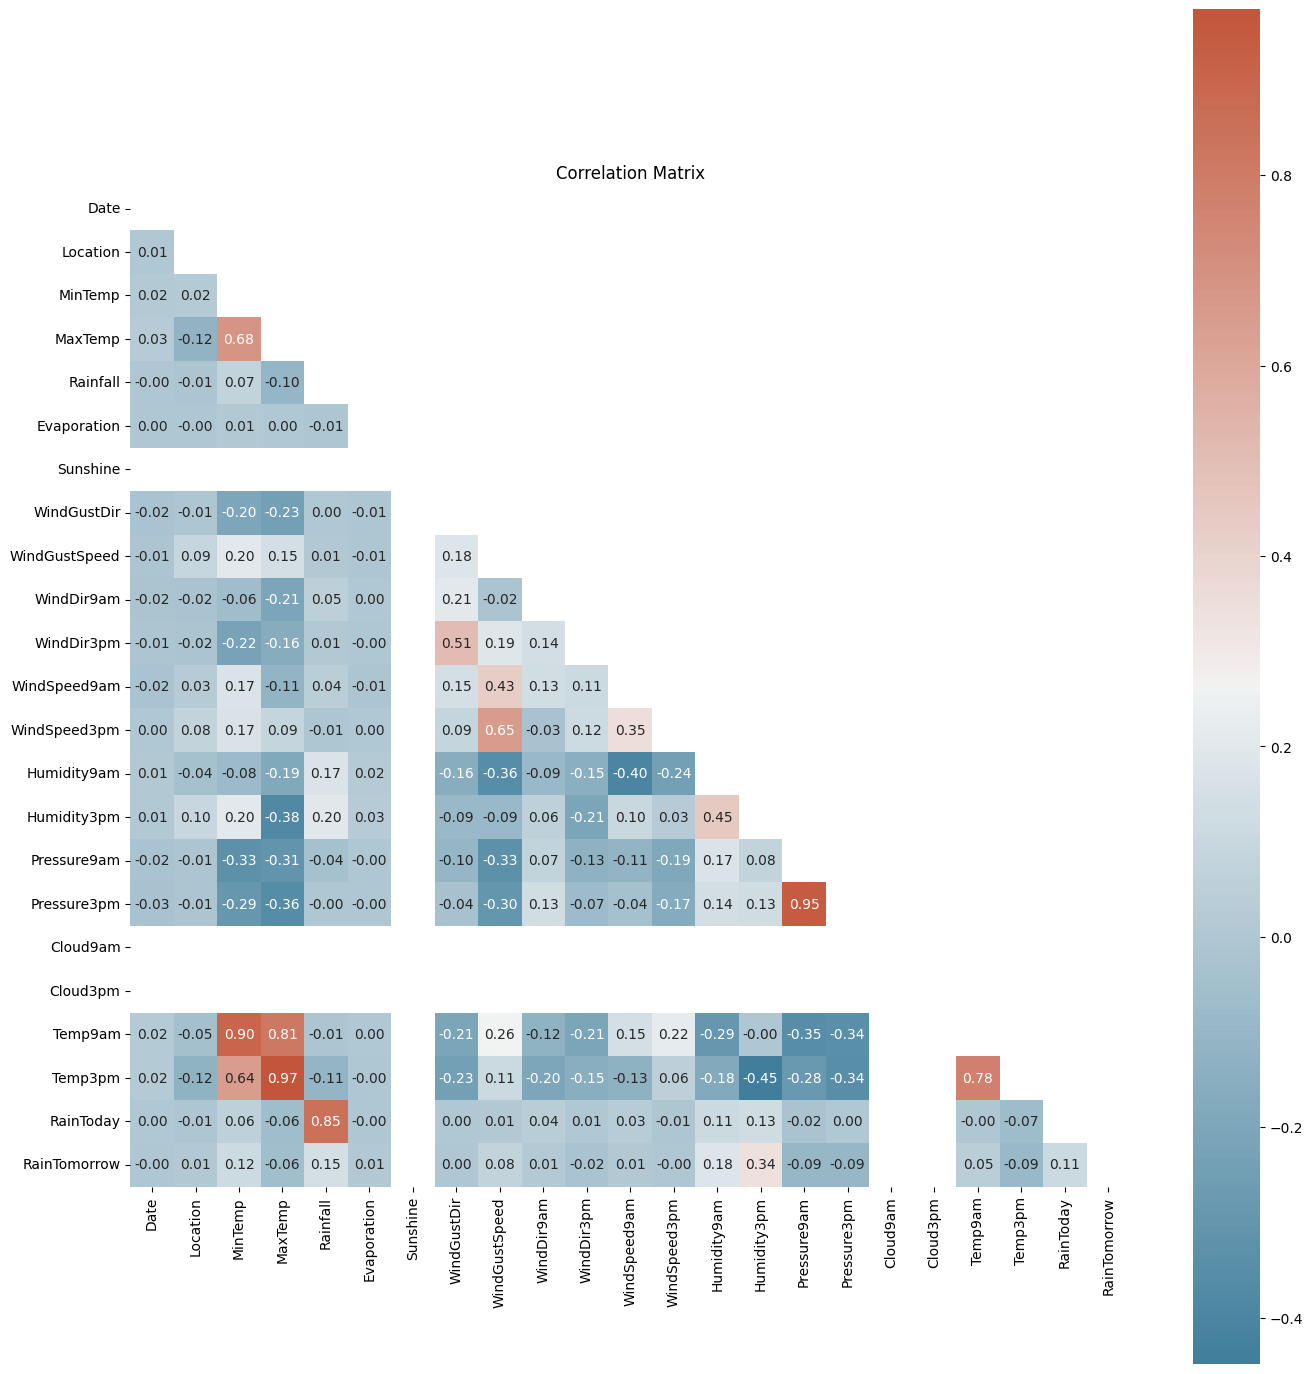

In [21]:
plt.figure(figsize=(14, 14)) # Now plt is defined and can be used
plt.title('Correlation Matrix')
# Creating a mask to block the top right half of the heatmap (redundant information)
mask = np.triu(np.ones_like(df.corr()))
# Custom color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(df.corr(), mask=mask, annot=True, fmt='.2f', square=True, cmap=cmap)
plt.tight_layout()
plt.savefig('images/corr_heatmap.png', facecolor='white', dpi=100);


<ipython-input-22-43bf1bd5e324>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RainToday',


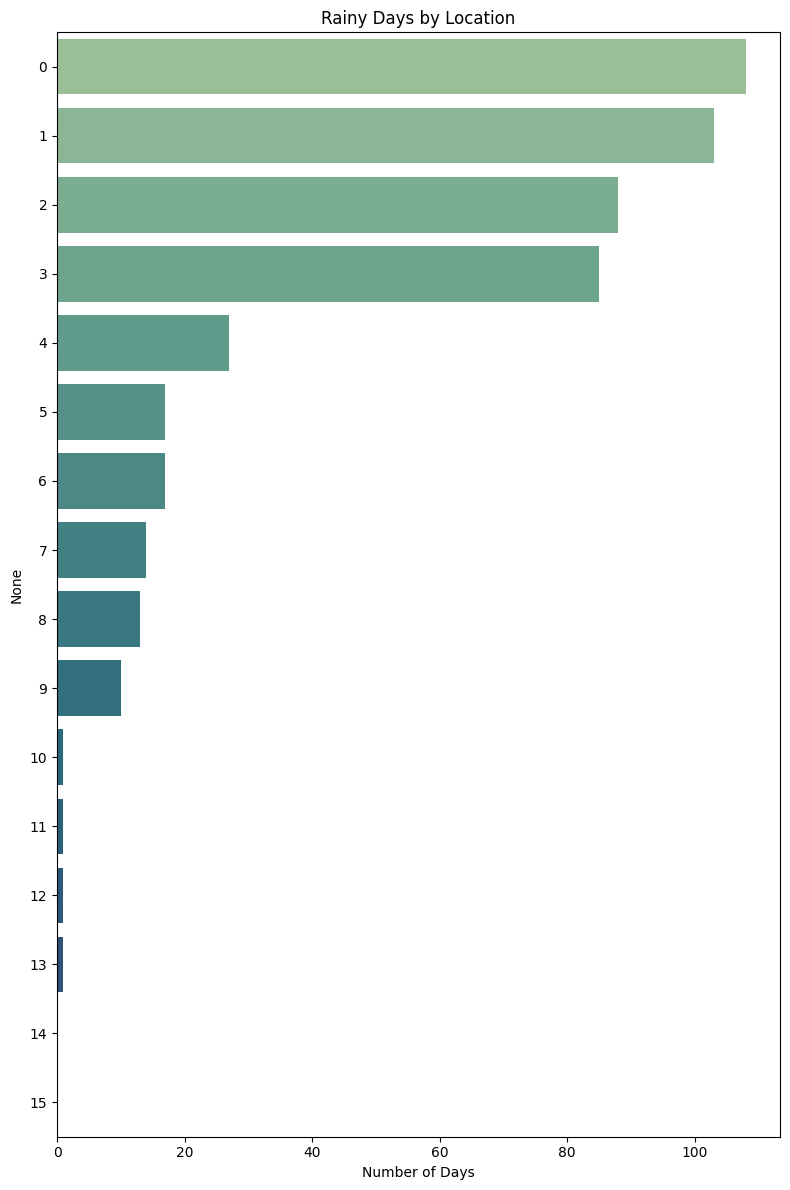

In [22]:



# Assuming 'df' is your main DataFrame containing weather data

# Create df_rain_by_loc by grouping by location and summing 'RainToday'
df_rain_by_loc = df.groupby('Location')['RainToday'].sum().reset_index()

plt.figure(figsize=(8, 12))
sns.barplot(x='RainToday',
            y=df_rain_by_loc.index,  # or y='Location' if 'Location' is a column
            data=df_rain_by_loc.sort_values('RainToday', ascending=False),
            orient='h',
            palette='crest'
            )
plt.xlabel('Number of Days')
plt.title('Rainy Days by Location')
plt.tight_layout()
plt.savefig('images/rainy_days_by_loc.png', facecolor='white', dpi=100);

In [23]:
import pandas as pd

# Assuming 'df' is your original DataFrame (replace if different):
df_imputed_final = df.copy() # Or load/create df_imputed_final here

# Convert the Date column to datetime format, and handle errors by coercing invalid dates to NaT (Not a Time)
df_imputed_final['Date'] = pd.to_datetime(df_imputed_final['Date'], errors='coerce')

# Check for any missing or invalid Date entries after conversion
missing_dates = df_imputed_final['Date'].isnull().sum()
print(f"Missing/Invalid Date entries: {missing_dates}")

# Drop rows where Date is missing (optional if Date is crucial)
df_imputed_final = df_imputed_final.dropna(subset=['Date'])

# Extract the Month from the Date column
df_month = df_imputed_final.copy()
df_month.insert(1, 'Month', df_month['Date'].dt.month)

# Drop the original Date column if no longer needed
df_month.drop(columns='Date', inplace=True)

# Check the first few rows of the updated dataframe
df_month.head()

Missing/Invalid Date entries: 0


,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
1,1,0,-0.759146,0.320543,-0.288632,-8.833311e-16,7.879284e-16,14,0.375190,6,...,-1.531348,-1.355264,-1.232223,86,0.0,4.408800e-16,0.064657,0.433823,0,0
3,1,0,-0.472938,0.767053,-0.288632,-8.833311e-16,7.879284e-16,4,-1.128488,9,...,-1.473157,-1.800916,-0.119373,142,0.0,4.408800e-16,0.219005,0.786747,0,0
5,1,0,0.385688,1.028800,-0.266941,-8.833311e-16,7.879284e-16,14,1.277397,13,...,-0.891239,-1.454298,-1.454793,60,0.0,4.408800e-16,0.647746,1.171755,0,0
7,1,0,-0.711445,0.566893,-0.288632,-8.833311e-16,7.879284e-16,13,-0.301465,10,...,-1.298581,-1.652365,-0.787083,113,0.0,4.408800e-16,-0.089690,0.626327,0,0
10,1,0,0.194882,1.136578,-0.288632,-8.833311e-16,7.879284e-16,3,-0.677385,10,...,-1.298581,-1.503814,-1.041449,96,0.0,4.408800e-16,0.613447,1.155713,0,1


In [24]:
categoricals = ['Month', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
df_dummies = pd.get_dummies(df_month, columns=categoricals)
df_dummies.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_6,WindDir3pm_7,WindDir3pm_8,WindDir3pm_9,WindDir3pm_10,WindDir3pm_11,WindDir3pm_12,WindDir3pm_13,WindDir3pm_14,WindDir3pm_15
1,-0.759146,0.320543,-0.288632,-8.833311e-16,7.879284e-16,0.375190,-0.974526,0.459460,-1.531348,-1.355264,...,False,False,False,False,False,False,False,False,False,True
3,-0.472938,0.767053,-0.288632,-8.833311e-16,7.879284e-16,-1.128488,-0.196378,-0.963369,-1.473157,-1.800916,...,False,False,False,False,False,False,False,False,False,False
5,0.385688,1.028800,-0.266941,-8.833311e-16,7.879284e-16,1.277397,0.692935,0.678357,-0.891239,-1.454298,...,False,False,False,False,False,False,False,True,False,False
7,-0.711445,0.566893,-0.288632,-8.833311e-16,7.879284e-16,-0.301465,-0.752198,-0.087782,-1.298581,-1.652365,...,False,False,False,False,False,False,False,True,False,False
10,0.194882,1.136578,-0.288632,-8.833311e-16,7.879284e-16,-0.677385,0.470607,-1.291714,-1.298581,-1.503814,...,False,False,False,False,False,False,False,False,False,False


#Splitting the dataset into training and test sets

In [25]:

df_final = df_dummies.copy()
X = df_final.drop(columns='RainTomorrow')
y = df_final.RainTomorrow
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('Train size:', X_train.shape[0])
print('Test size: ', X_test.shape[0])

Train size: 9616
Test size:  3206


#Modeling

#Logistic Regression

In [26]:

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([0, 0, 0, ..., 0, 0, 0])

Confusion Matrix
-----------------------------------------------------


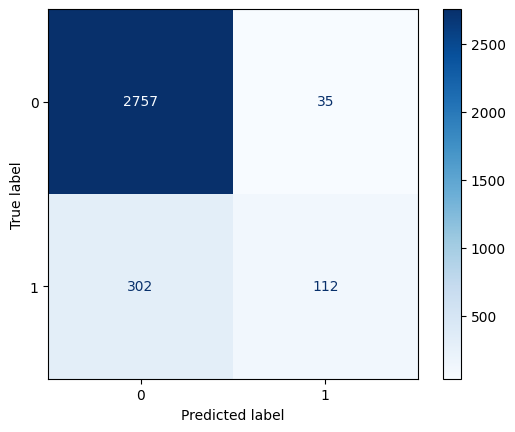



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2792
           1       0.76      0.27      0.40       414

    accuracy                           0.89      3206
   macro avg       0.83      0.63      0.67      3206
weighted avg       0.88      0.89      0.87      3206



ROC Curve
-----------------------------------------------------


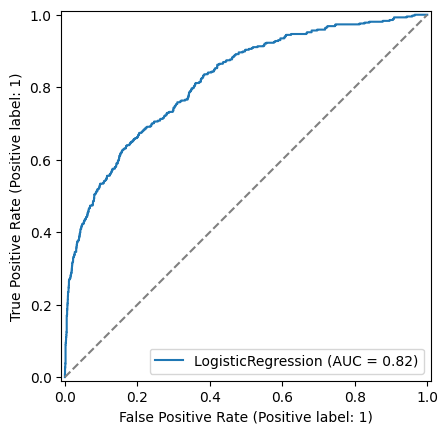



Checking model fitness
-----------------------------------------------------
Train score: 0.8941
Test score:  0.8949




In [27]:
!pip install scikit-learn  # Install scikit-learn if not already installed

import matplotlib.pyplot as plt # Import matplotlib.pyplot
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report #Import required functions from sklearn.metrics


# ... (Rest of your code remains unchanged) ...

def conf_matrix(model, X_test, y_test, cmap='Blues'):
    # Use ConfusionMatrixDisplay instead of plot_confusion_matrix
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap=cmap)
    disp.ax_.grid(False) # Turn off grid lines (optional)
    plt.show()

def roc_curve_custom(model, X_test, y_test):
    #Use RocCurveDisplay instead of plot_roc_curve
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.show()


def evaluate(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, y_pred=y_pred):
 # Confusion Matrix
 print('Confusion Matrix')
 print('-'*53)
 conf_matrix(model, X_test, y_test)
 print('\n')

 # Classification Report
 print('Classification Report')
 print('-'*53)
 print(classification_report(y_test, y_pred))
 print('\n')

 # ROC Curve
 print('ROC Curve')
 print('-'*53)
 roc_curve_custom(model, X_test, y_test)
 print('\n')

 # Checking model fitness
 print('Checking model fitness')
 print('-'*53)
 print('Train score:', round(model.score(X_train, y_train), 4))
 print('Test score: ', round(model.score(X_test, y_test), 4))
 print('\n')

evaluate(logreg)

#Correcting Class Imbalance

In [28]:

X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)
print('Original')
print('-'*20)
print(y_train.value_counts())
print('\n')
print('SMOTE')
print('-'*20)
print(pd.Series(y_train_resampled).value_counts())

Original
--------------------
RainTomorrow
0    8382
1    1234
Name: count, dtype: int64


SMOTE
--------------------
RainTomorrow
0    8382
1    8382
Name: count, dtype: int64


In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Step 1: Standardize the data (scaling)
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)

# Transform the test data using the same scaler (without refitting)
X_test_scaled = scaler.transform(X_test)

# Step 2: Train the logistic regression model with more iterations
logreg_smote = LogisticRegression(random_state=42, max_iter=1000)  # Increase max_iter
logreg_smote.fit(X_train_resampled_scaled, y_train_resampled)

# Step 3: Predict using the scaled test data
y_pred_smote = logreg_smote.predict(X_test_scaled)

# Display the predictions
y_pred_smote


array([0, 0, 0, ..., 0, 0, 0])

Confusion Matrix
-----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


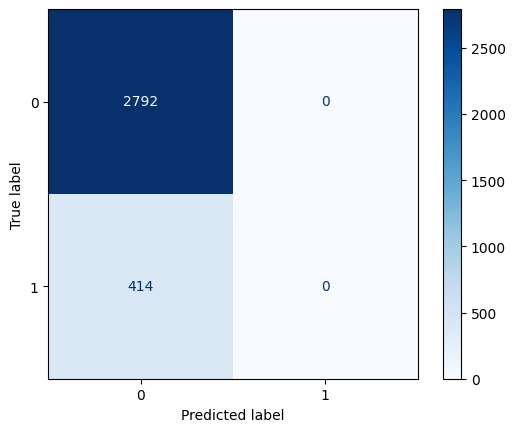



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2792
           1       0.65      0.34      0.45       414

    accuracy                           0.89      3206
   macro avg       0.78      0.66      0.69      3206
weighted avg       0.88      0.89      0.88      3206



ROC Curve
-----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


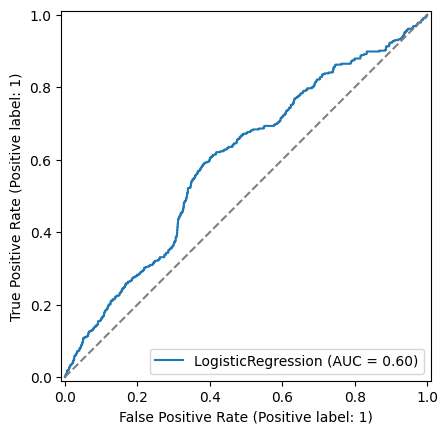



Checking model fitness
-----------------------------------------------------
Train score: 0.5
Test score:  0.8709




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [30]:
 evaluate(logreg_smote, X_train=X_train_resampled, y_train=y_train_resampled, y_pred=y_pred_smote)

#Hyperparameter Tuning

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the base logistic regression model
logreg = LogisticRegression()

# Define the parameter grid for GridSearchCV
logreg_params = {
    'C': [1, 1e8, 1e16],
    'fit_intercept': [True, False],
    'max_iter': [50, 100, 150],
    'random_state': [42]  # Fixed random state
}

# Set up GridSearchCV with 3-fold cross-validation
logreg_gs = GridSearchCV(logreg, logreg_params, scoring='accuracy', cv=3)

# Fit the model on the training data
logreg_gs.fit(X_train, y_train)

# Get the best estimator (model with best parameters)
best_logreg = logreg_gs.best_estimator_




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [32]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [33]:
# Initialize the logistic regression model with a higher max_iter
logreg = LogisticRegression(max_iter=500, random_state=42)

# Define the parameter grid with higher iterations
logreg_params = {
    'C': [1, 1e8, 1e16],
    'fit_intercept': [True, False],
    'max_iter': [300, 500, 700],  # Increased the number of iterations
    'random_state': [42]
}

# GridSearchCV
logreg_gs = GridSearchCV(logreg, logreg_params, scoring='accuracy', cv=3)
logreg_gs.fit(X_train_scaled, y_train)

# Get the best model and parameters
best_logreg = logreg_gs.best_estimator_

# Print best estimator and best parameters
print("Best Estimator:", best_logreg)
print("Best Parameters:", logreg_gs.best_params_)


Best Estimator: LogisticRegression(C=100000000.0, max_iter=300, random_state=42)
Best Parameters: {'C': 100000000.0, 'fit_intercept': True, 'max_iter': 300, 'random_state': 42}


In [34]:
# Make predictions on the scaled test data
y_pred = best_logreg.predict(X_test_scaled)

# Print the predicted values
print("Predicted values:", y_pred)


Predicted values: [0 0 0 ... 0 0 0]


In [35]:


# Check the class distribution in the target variable
print("Class distribution in training data:", np.bincount(y_train))
print("Class distribution in test data:", np.bincount(y_test))


Class distribution in training data: [8382 1234]
Class distribution in test data: [2792  414]


In [36]:

# Step 1: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Step 2: Initialize the logistic regression model
logreg = LogisticRegression(max_iter=500, random_state=42, solver='liblinear', class_weight='balanced')

# Step 3: Define the parameter grid for GridSearchCV
logreg_params = {
    'C': [0.01, 1, 100],
    'fit_intercept': [True, False],
    'max_iter': [500, 1000, 1500],
    'random_state': [42]
}

# Step 4: Perform Grid Search with 'f1' as the scoring metric (or 'roc_auc' for AUC-ROC)
logreg_gs = GridSearchCV(logreg, logreg_params, scoring='f1', cv=3)
logreg_gs.fit(X_train_resampled, y_train_resampled)

# Step 5: Get the best model and parameters
best_logreg = logreg_gs.best_estimator_

# Step 6: Make predictions on the scaled test data
y_pred = best_logreg.predict(X_test_scaled)

# Step 7: Evaluate the model's performance
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 8: Print the predicted values
print("Predicted values:", y_pred)

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.59      0.73      2792
           1       0.23      0.85      0.36       414

    accuracy                           0.62      3206
   macro avg       0.60      0.72      0.55      3206
weighted avg       0.87      0.62      0.68      3206

Predicted values: [0 0 0 ... 1 0 1]


Confusion Matrix
-----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


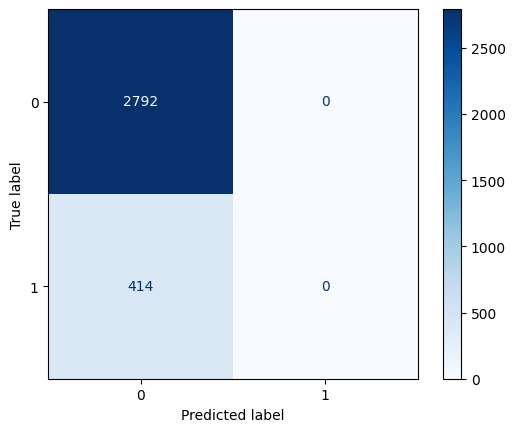



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.59      0.73      2792
           1       0.23      0.85      0.36       414

    accuracy                           0.62      3206
   macro avg       0.60      0.72      0.55      3206
weighted avg       0.87      0.62      0.68      3206



ROC Curve
-----------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


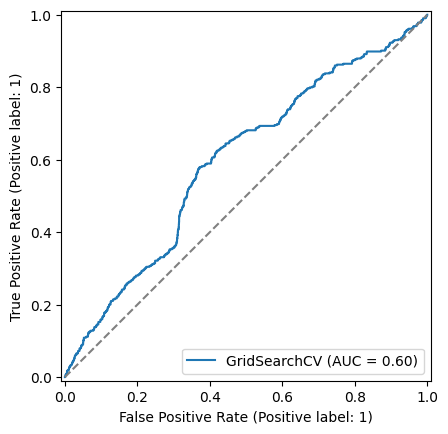



Checking model fitness
-----------------------------------------------------
Train score: 0.0
Test score:  0.0




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [37]:
# Make predictions on the scaled test data using the best logistic regression model
y_pred_logreg_gs = best_logreg.predict(X_test_scaled)

# Evaluate the model using the predicted values
evaluate(logreg_gs, y_pred=y_pred_logreg_gs)

#Decision Tree

In [38]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
y_pred_tree

array([0, 0, 0, ..., 0, 0, 1])

Confusion Matrix
-----------------------------------------------------


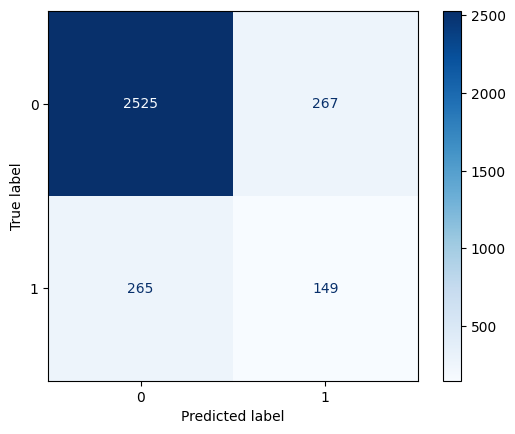



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2792
           1       0.36      0.36      0.36       414

    accuracy                           0.83      3206
   macro avg       0.63      0.63      0.63      3206
weighted avg       0.83      0.83      0.83      3206



ROC Curve
-----------------------------------------------------


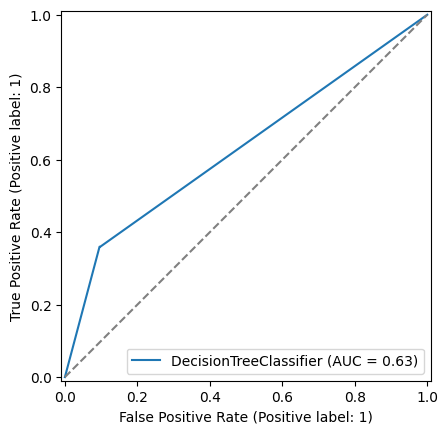



Checking model fitness
-----------------------------------------------------
Train score: 0.9998
Test score:  0.8341




In [39]:
evaluate(clf, y_pred=y_pred_tree)

#Hyperparameter Tuning

In [40]:

params = {
 'criterion': ['gini', 'entropy'],
 'max_depth': [3, 7, 11],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 3, 5],
 'random_state': [42]
}
clf_gs = GridSearchCV(clf, param_grid=params, scoring='accuracy', cv=3)
clf_gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 7, 11], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'random_state': [42]},
             scoring='accuracy')

In [41]:
import os
import joblib

# Create the 'saved_models' directory if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

# Now you can safely save the model
joblib.dump(clf_gs, 'saved_models/clf_gs.joblib')

['saved_models/clf_gs.joblib']

In [42]:

clf_gs = joblib.load('saved_models/clf_gs.joblib')


In [43]:
import joblib

# Load the model
clf_gs = joblib.load('saved_models/clf_gs.joblib')

# Re-fit the model if necessary (If you have new data or haven't fit it before)
# Assuming X_train and y_train are your training data
# clf_gs.fit(X_train, y_train)

# Access the best parameters
clf_gs.best_params_  # Notice the underscore (_) at the end

{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'random_state': 42}

In [44]:

round(clf_gs.best_score_, 4)


0.8874

In [45]:

y_pred_tree_gs = clf_gs.best_estimator_.predict(X_test)
y_pred_tree_gs


array([0, 0, 0, ..., 0, 0, 0])

Confusion Matrix
-----------------------------------------------------


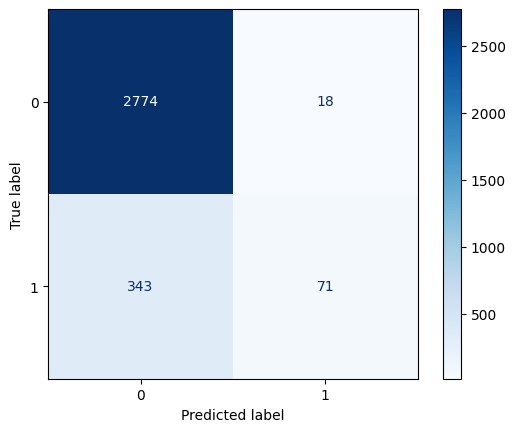



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2792
           1       0.80      0.17      0.28       414

    accuracy                           0.89      3206
   macro avg       0.84      0.58      0.61      3206
weighted avg       0.88      0.89      0.85      3206



ROC Curve
-----------------------------------------------------


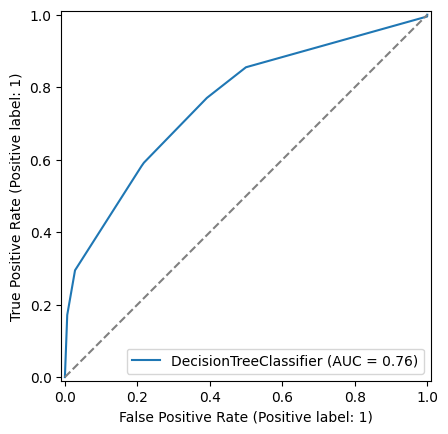



Checking model fitness
-----------------------------------------------------
Train score: 0.8881
Test score:  0.8874




In [46]:

evaluate(clf_gs.best_estimator_, y_pred=y_pred_tree_gs)

#XGBoost

In [47]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Step 1: Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 2: Fine-tune the XGBClassifier using GridSearchCV
xgb = XGBClassifier(random_state=42)

# Calculate scale_pos_weight based on class distribution
# This assumes y_train is a pandas Series or a numpy array
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
#If y_train is not pandas series, convert to pandas series, e.g.
#scale_pos_weight = (pd.Series(y_train) == 0).sum() / (pd.Series(y_train) == 1).sum()

# Define parameter grid for XGBClassifier
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'scale_pos_weight': [1, scale_pos_weight]  # Use balanced and original weight
}

# Step 3: Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1', cv=3)
grid_search.fit(X_train_resampled, y_train_resampled)

# Step 4: Train the model with the best parameters
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train_resampled, y_train_resampled)

# Step 5: Make predictions on the test set
y_pred_xgb = best_xgb.predict(X_test_scaled)

# Step 6: Evaluate the model's performance
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Step 7: Print the predicted values
print("Predicted values:", y_pred_xgb)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.60      0.73      2792
           1       0.23      0.79      0.35       414

    accuracy                           0.62      3206
   macro avg       0.59      0.69      0.54      3206
weighted avg       0.86      0.62      0.68      3206

Predicted values: [0 1 1 ... 1 0 0]


Confusion Matrix
-----------------------------------------------------


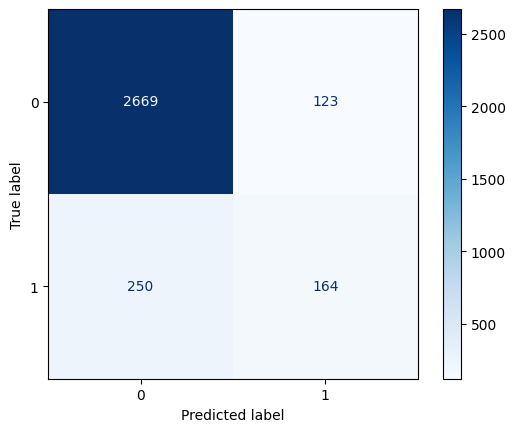



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.60      0.73      2792
           1       0.23      0.79      0.35       414

    accuracy                           0.62      3206
   macro avg       0.59      0.69      0.54      3206
weighted avg       0.86      0.62      0.68      3206



ROC Curve
-----------------------------------------------------


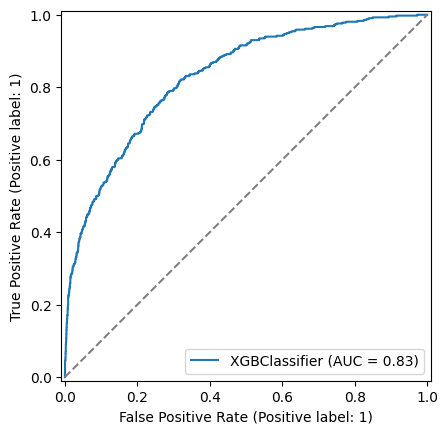



Checking model fitness
-----------------------------------------------------
Train score: 0.9773
Test score:  0.8837




In [48]:
evaluate(best_xgb, y_pred=y_pred_xgb) # Use best_xgb instead of xgb

#Hyperparameter Tuning

In [49]:

xgb_params = {
 'n_estimators': [10, 35, 100],
 'max_depth': [5, 10, 15],
 'learning_rate': [0.01, 0.1, 0.25]
}
xgb_gs = GridSearchCV(xgb, xgb_params, scoring='accuracy', cv=3)
xgb_gs.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.25],
                         'max_depth': [5, 10, 15],
                         'n_estimators': [10, 35, 100]},
             scoring='accuracy')

In [50]:

joblib.dump(xgb_gs, 'saved_models/xgb_gs.joblib')

['saved_models/xgb_gs.joblib']

In [51]:

xgb_gs = joblib.load('saved_models/xgb_gs.joblib')


In [52]:

xgb_gs.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

In [53]:

round(xgb_gs.best_score_, 4)


0.8926

In [54]:

y_pred_xgb_gs = xgb_gs.predict(X_test)
y_pred_xgb_gs

array([0, 0, 0, ..., 0, 0, 0])

Confusion Matrix
-----------------------------------------------------


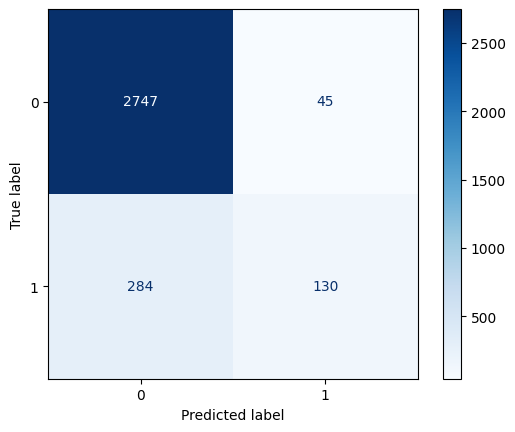



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2792
           1       0.74      0.31      0.44       414

    accuracy                           0.90      3206
   macro avg       0.82      0.65      0.69      3206
weighted avg       0.89      0.90      0.88      3206



ROC Curve
-----------------------------------------------------


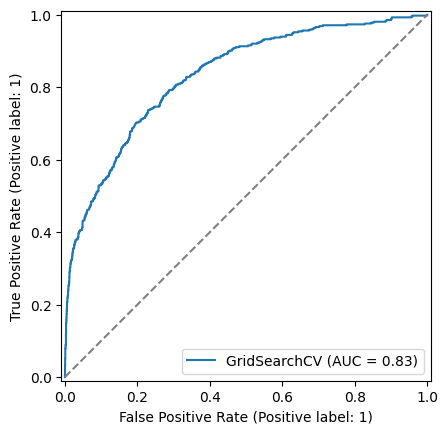



Checking model fitness
-----------------------------------------------------
Train score: 0.9221
Test score:  0.8974




In [55]:

evaluate(xgb_gs, y_pred=y_pred_xgb_gs)

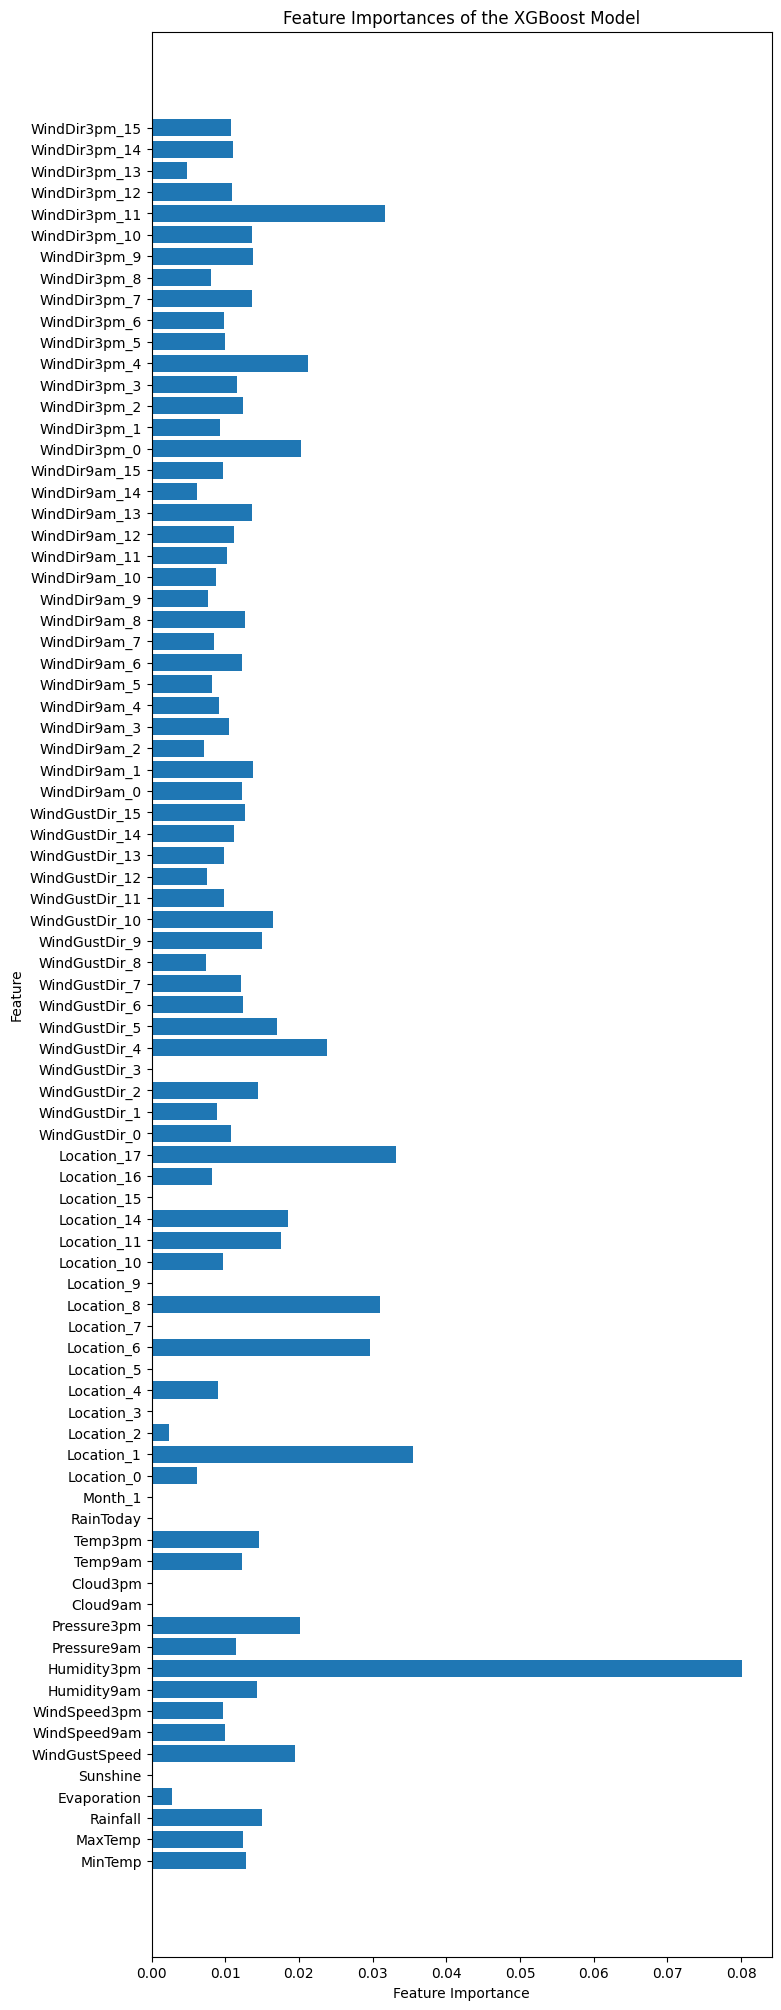

In [56]:


best_xgb = xgb_gs.best_estimator_
plt.figure(figsize=(8, 25))
plt.barh(range(best_xgb.n_features_in_), best_xgb.feature_importances_)
plt.yticks(np.arange(best_xgb.n_features_in_), X_train.columns.values)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of the XGBoost Model');

In [57]:

feat_imp_df = pd.DataFrame(data={'Feature': df_final.columns.drop('RainTomorrow'),
 'Importance': best_xgb.feature_importances_
 }
 )
feat_imp_df['Group'] = feat_imp_df.Feature.apply(lambda x: x.split('_')[0])
feat_imp_df


,Feature,Importance,Group
0,MinTemp,0.012756,MinTemp
1,MaxTemp,0.012397,MaxTemp
2,Rainfall,0.014997,Rainfall
3,Evaporation,0.002807,Evaporation
4,Sunshine,0.000000,Sunshine
...,...,...,...
77,WindDir3pm_11,0.031624,WindDir3pm
78,WindDir3pm_12,0.010953,WindDir3pm
79,WindDir3pm_13,0.004853,WindDir3pm
80,WindDir3pm_14,0.011083,WindDir3pm


In [58]:

feat_imp_df.Group.value_counts()

,count
Group,
WindDir3pm,16
WindDir9am,16
WindGustDir,16
Location,16
MaxTemp,1
Month,1
RainToday,1
Temp3pm,1
Temp9am,1


In [59]:

feat_imp_df_grouped = feat_imp_df.groupby(by='Group').sum()
feat_imp_df_grouped.sort_values('Importance', ascending=False, inplace=True)
feat_imp_df_grouped

,Feature,Importance
Group,,
WindDir3pm,WindDir3pm_0WindDir3pm_1WindDir3pm_2WindDir3pm...,0.213149
Location,Location_0Location_1Location_2Location_3Locati...,0.200916
WindGustDir,WindGustDir_0WindGustDir_1WindGustDir_2WindGus...,0.189285
WindDir9am,WindDir9am_0WindDir9am_1WindDir9am_2WindDir9am...,0.161649
Humidity3pm,Humidity3pm,0.080131
Pressure3pm,Pressure3pm,0.020140
WindGustSpeed,WindGustSpeed,0.019454
Rainfall,Rainfall,0.014997
Temp3pm,Temp3pm,0.014627


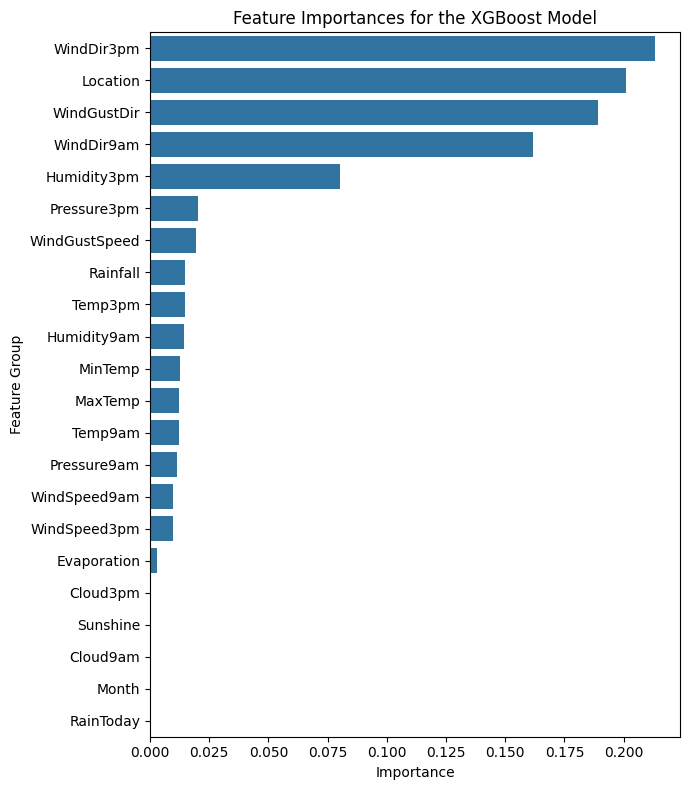

In [60]:

plt.figure(figsize=(7, 8))
sns.barplot(y=feat_imp_df_grouped.index,
 x=feat_imp_df_grouped.Importance,
 orient='h',
 color=sns.color_palette()[0]
 )
plt.title('Feature Importances for the XGBoost Model')
plt.ylabel('Feature Group')
plt.xlabel('Importance')
plt.tight_layout()
plt.savefig('images/feat_importances.png', facecolor='white', dpi=100);


#Model Comparisons

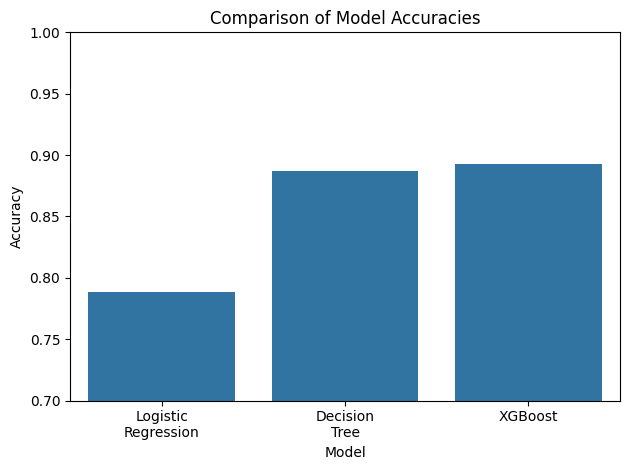

In [61]:
models = [logreg_gs, clf_gs, xgb_gs]
sns.barplot(x=['Logistic\nRegression', 'Decision\nTree',  'XGBoost'],
 y=[model.best_score_ for model in models]
 )
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.title('Comparison of Model Accuracies')
plt.tight_layout()
plt.savefig('images/model_accuracies.png', facecolor='white', dpi=100);

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


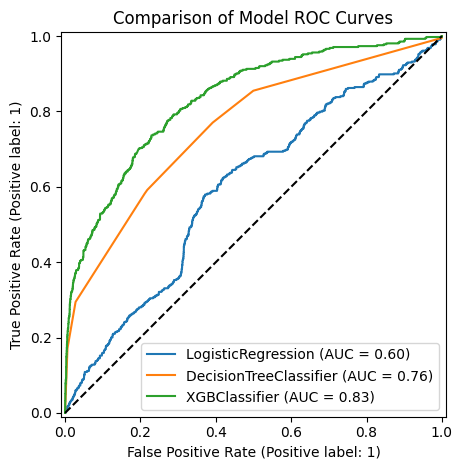

In [62]:
!pip install scikit-learn
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()
for model in models:
 RocCurveDisplay.from_estimator(
 model,
 X_test,
 y_test,
 name=type(model.best_estimator_).__name__,
 ax=ax
 )
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Comparison of Model ROC Curves')
plt.tight_layout()
plt.savefig('images/model_roc_curves.png', facecolor='white', dpi=100);